**Importing of relevant libraries**

In [265]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier, RidgeClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import BernoulliNB
from scipy.stats import loguniform, randint, uniform
from xgboost import XGBClassifier


import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


**Data Cleaning and Preparation**

In [266]:
#loading the data into the environment 
data_raw = pd.read_csv('/kaggle/input/titanic/train.csv')
data_val  = pd.read_csv('/kaggle/input/titanic/test.csv')

In [267]:
#splitting the data into features and labels
target = data_raw['Survived'].copy()
data_raw = data_raw.drop('Survived' , axis = 1) 

In [268]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [269]:
data_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [270]:
data_raw.nunique()

PassengerId    891
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [271]:
#Categorical Features
cat_feats = ['Sex','Pclass', 'Embarked']

#Numerical Features
num_feats = ['Fare', 'Age', 'SibSp', 'Parch']

#Qualitative Features
qual_feats = ['Ticket', 'Cabin', 'Name', 'PassengerId']

In [272]:
#Drop the Qualitative Features
data_raw.drop(qual_feats, axis=1)
data_val.drop(qual_feats, axis=1)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,S
414,1,female,39.0,0,0,108.9000,C
415,3,male,38.5,0,0,7.2500,S
416,3,male,NaN,0,0,8.0500,S


In [273]:
#Creating data processing pipeline
num_pipeline = Pipeline([
    ('imputer' , SimpleImputer(strategy='mean')) , 
    ('std_scaler' , StandardScaler()) , 
])


full_pipeline = ColumnTransformer([
    ('num' , num_pipeline , num_feats) , 
    ('cat' , OneHotEncoder() , cat_feats) ,
])


full_pipeline.fit(data_raw)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['Fare', 'Age', 'SibSp', 'Parch']),
                                ('cat', OneHotEncoder(),
                                 ['Sex', 'Pclass', 'Embarked'])])

In [274]:
data_raw_prepared = full_pipeline.transform(data_raw)
data_val_prepared = full_pipeline.transform(data_val)

In [275]:
#splitting training data into a training set and a test set
X_train, X_test, y_train,  y_test = train_test_split(data_raw_prepared, target, test_size = 0.1, random_state = 28, stratify = target)

**Models Accuracy Scores Pre-hyperparameter tuning**

In [276]:
#Instantiating the models 
sgd_clf = SGDClassifier()
ridge_clf = RidgeClassifierCV()
adaboost_clf = AdaBoostClassifier()
gradientboosting_clf = GradientBoostingClassifier()
randomforest_clf = RandomForestClassifier()
bernoulli = BernoulliNB()
xgboost_clf = XGBClassifier()  

In [277]:
models = [sgd_clf, ridge_clf, adaboost_clf, gradientboosting_clf, randomforest_clf, bernoulli, xgboost_clf]
accuracy_scores = []

for model in models:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

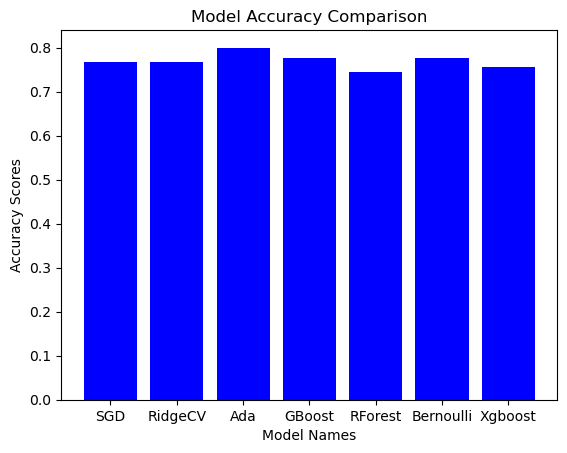

In [278]:
model_names = ['SGD', 'RidgeCV', 'Ada', 'GBoost', 'RForest', 'Bernoulli', 'Xgboost']

plt.bar(model_names, accuracy_scores, color='blue')

plt.xlabel('Model Names')
plt.ylabel('Accuracy Scores')
plt.title('Model Accuracy Comparison')

plt.show()

**Hyperparameter Tuning**

In [279]:
#sgd classifier
param_dist = {
    'loss': ['hinge', 'modified_huber', 'squared_hinge'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': loguniform(1e-6, 1e-2),
    'max_iter': [50 ,100, 200, 300, 400, 500, 600],
    'tol': loguniform(1e-6, 1e-3),
    'learning_rate': ['optimal', 'adaptive'],
    'eta0': loguniform(1e-4, 1e-1)
}


sgd_random_search = RandomizedSearchCV(
    sgd_clf, param_distributions=param_dist, n_iter=40,
    cv=5, n_jobs=-1, random_state=28
)


sgd_random_search.fit(X_train, y_train)


print("Best Parameters:", sgd_random_search.best_params_)
print("Best Score:", sgd_random_search.best_score_)

best_sgd_clf = SGDClassifier(**sgd_random_search.best_params_)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best Parameters: {'alpha': 0.0009700639537406769, 'eta0': 0.03773605281317524, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 500, 'penalty': 'l1', 'tol': 8.168087791878444e-05}
Best Score: 0.802748447204969


In [280]:
#ridge classifier cv
param_dist = {
    'cv': [3, 5, 10],  
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced']
}


ridge_random_search = RandomizedSearchCV(
    ridge_clf, param_distributions=param_dist, n_iter=40,
    cv=5, n_jobs=-1, random_state=28
)

ridge_random_search.fit(X_train, y_train)


print("Best Parameters:", ridge_random_search.best_params_)
print("Best Score:", ridge_random_search.best_score_)

best_ridge_clf = RidgeClassifierCV(**ridge_random_search.best_params_)

Best Parameters: {'fit_intercept': True, 'cv': 3, 'class_weight': None}
Best Score: 0.7952795031055901


In [281]:
#adaboost classifier
param_dist = {
    'n_estimators': randint(50, 200), 
    'learning_rate': uniform(0.01, 1.0),
    'algorithm': ['SAMME', 'SAMME.R']
}


adaboost_random_search = RandomizedSearchCV(
    adaboost_clf, param_distributions=param_dist, n_iter=40,
    cv=5, n_jobs=-1, random_state=28
)


adaboost_random_search.fit(X_train, y_train)


print("Best Parameters:", adaboost_random_search.best_params_)
print("Best Score:", adaboost_random_search.best_score_)

best_adaboost_clf = AdaBoostClassifier(**adaboost_random_search.best_params_)

Best Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.9446484613073758, 'n_estimators': 144}
Best Score: 0.8165139751552795


In [282]:
#gradient boosting classifier
param_dist = {
    'n_estimators': randint(50, 200),  
    'learning_rate': uniform(0.01, 0.5),
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'subsample': uniform(0.5, 1.0),
}


Gboost_random_search = RandomizedSearchCV(
    gradientboosting_clf, param_distributions=param_dist, n_iter=40,
    cv=5, n_jobs=-1, random_state=28
)


Gboost_random_search.fit(X_train, y_train)


print("Best Parameters:", Gboost_random_search.best_params_)
print("Best Score:", Gboost_random_search.best_score_)

best_Gboost_clf = GradientBoostingClassifier(**Gboost_random_search.best_params_)

Best Parameters: {'learning_rate': 0.25364630871504756, 'max_depth': 2, 'min_samples_leaf': 19, 'min_samples_split': 2, 'n_estimators': 90, 'subsample': 0.865697510726118}
Best Score: 0.8464906832298137


In [283]:
#random forest classifier
param_dist = {
    'n_estimators': randint(50, 200),  
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}


RForest_random_search = RandomizedSearchCV(
    randomforest_clf, param_distributions=param_dist, n_iter=40,
    cv=5, n_jobs=-1, random_state=28
)


RForest_random_search.fit(X_train, y_train)


print("Best Parameters:", RForest_random_search.best_params_)
print("Best Score:", RForest_random_search.best_score_)

best_RForest_clf = RandomForestClassifier(**RForest_random_search.best_params_)

Best Parameters: {'bootstrap': False, 'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 58}
Best Score: 0.8390062111801242


In [284]:
#naive bayes bernoulli 
param_dist = {
    'alpha': uniform(0.1, 2.0),  
    'binarize': uniform(0.0, 1.0)  
}


bernoulli_random_search = RandomizedSearchCV(
    bernoulli, param_distributions=param_dist, n_iter=40,
    cv=5, n_jobs=-1, random_state=28
)


bernoulli_random_search.fit(X_train, y_train)


print("Best Parameters:", bernoulli_random_search.best_params_)
print("Best Score:", bernoulli_random_search.best_score_)

best_bernoulli = BernoulliNB(**bernoulli_random_search.best_params_)

Best Parameters: {'alpha': 2.0107437852696184, 'binarize': 0.9842134682517789}
Best Score: 0.7815217391304348


In [285]:
#xgboost 
param_dist = {
    'n_estimators': randint(50, 200),  
    'learning_rate': uniform(0.01, 0.5),
    'max_depth': randint(1, 10),
    'min_child_weight': randint(1, 20),
    'gamma': uniform(0, 1),
    'subsample': uniform(0.5, 1),
    'colsample_bytree': uniform(0.5, 1),
    'scale_pos_weight': uniform(1, 10)
}


xgboost_random_search = RandomizedSearchCV(
    xgboost_clf, param_distributions=param_dist, n_iter=40,
    cv=5, n_jobs=-1, random_state=28
)


xgboost_random_search.fit(X_train, y_train)


print("Best Parameters:", xgboost_random_search.best_params_)
print("Best Score:", xgboost_random_search.best_score_)

best_xgboost_clf = XGBClassifier(**xgboost_random_search.best_params_)

Best Parameters: {'colsample_bytree': 0.8950475469759708, 'gamma': 0.06883798333383306, 'learning_rate': 0.16682838004573342, 'max_depth': 9, 'min_child_weight': 10, 'n_estimators': 159, 'scale_pos_weight': 1.286459949826784, 'subsample': 0.9550220170800784}
Best Score: 0.8440062111801243


**Models Accuracy Scores Post-hyperparameter tuning**

In [286]:
best_models = [best_sgd_clf, best_ridge_clf, best_adaboost_clf, best_Gboost_clf, best_RForest_clf, best_bernoulli, best_xgboost_clf]
accuracy_scores = []

for model in best_models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

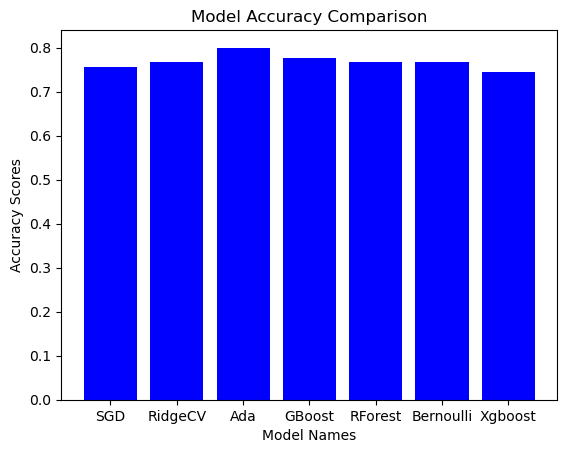

In [287]:
model_names = ['SGD', 'RidgeCV', 'Ada', 'GBoost', 'RForest', 'Bernoulli', 'Xgboost']

plt.bar(model_names, accuracy_scores, color='blue')

plt.xlabel('Model Names')
plt.ylabel('Accuracy Scores')
plt.title('Model Accuracy Comparison')

plt.show()

**Ensemble Learning Model**

In [288]:
best_models = [
    ('SGD', best_sgd_clf),
    ('RidgeCV', best_ridge_clf),
    ('Ada', best_adaboost_clf),
    ('GBoost', best_Gboost_clf),
    ('RForest', best_RForest_clf),
    ('Bernoulli', best_bernoulli),
    ('Xgboost', best_xgboost_clf)
]


voting_hard = VotingClassifier(estimators=best_models, voting='hard')

voting_hard.fit(X_train, y_train)

y_pred_hard = voting_hard.predict(X_test)
accuracy_hard = accuracy_score(y_test, y_pred_hard)
print("Hard Voting Test Accuracy:", accuracy_hard)

Hard Voting Test Accuracy: 0.7777777777777778


In [289]:
answer_set_pred = voting_hard.predict(data_val_prepared)

In [290]:
output = pd.DataFrame({'PassengerId': data_val.PassengerId, 'Survived': answer_set_pred})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
